In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ys19-2023-assignment-2/sample_submission.csv
/kaggle/input/ys19-2023-assignment-2/test_set.csv
/kaggle/input/ys19-2023-assignment-2/valid_set.csv
/kaggle/input/ys19-2023-assignment-2/train_set.csv
/kaggle/input/greek-stopwords-lowercase/custom_greek_stopwords_lowercase.csv
/kaggle/input/greek-stemmer/GreekStemmer.py


# Load and Pre-process Data

In [2]:
import re
from nltk.tokenize import word_tokenize
import sys
sys.path.append('../input/greek-stemmer')
import unicodedata


def remove_urls(text):
    text = re.sub(r'http\S+|www\S+|https\S', '', text)
    return text

def remove_hashtags_mentions(text):
    hashtags = re.findall(r'\#\w+', text)
    for hashtag in hashtags:
        split_words = hashtag[1:].split('_')
        text = text.replace(hashtag, ' '.join(split_words))
    text = re.sub(r'\@\w+', '', text)
    return text

def remove_punctuations(text):
    text = re.sub(r'[.,!?:;/()|&]+', '', text)
    return text

def remove_special_characters(text):
    text = re.sub(r'[\"«»-]', '', text)
    return text

def strip_accents_and_lowercase(s):
   return ''.join(c for c in unicodedata.normalize('NFD', s)
                  if unicodedata.category(c) != 'Mn').lower()

def preprocess_tweets(text, stopwords=True):
    text = remove_urls(text)
    text = remove_hashtags_mentions(text)
    text = remove_punctuations(text)
    text = remove_special_characters(text)
    text = strip_accents_and_lowercase(text)
    if stopwords:
        tokens = word_tokenize(text)
        custom_greek_stopwords = pd.read_csv('../input/greek-stopwords-lowercase/custom_greek_stopwords_lowercase.csv',
                                                 delimiter='\t')
        greek_stopwords = set(custom_greek_stopwords['greek_stopwords'].values.flatten().tolist())
        tokens = [token for token in tokens if token not in greek_stopwords]
        return " ".join(tokens)
    else:
        return text
    

train_data = pd.read_csv('../input/ys19-2023-assignment-2/train_set.csv')
valid_data = pd.read_csv('../input/ys19-2023-assignment-2/valid_set.csv')
test_data = pd.read_csv('../input/ys19-2023-assignment-2/test_set.csv')

train_data['Text'] = train_data['Text'].apply(preprocess_tweets)
valid_data['Text'] = valid_data['Text'].apply(preprocess_tweets)
test_data['Text'] = test_data['Text'].apply(preprocess_tweets)

# Load pre-trained Word2Vec model

In [3]:
from gensim.models import Word2Vec, KeyedVectors
!wget http://vectors.nlpl.eu/repository/20/46.zip
!unzip -o 46.zip

word2vec_greek_model = KeyedVectors.load_word2vec_format('model.bin', binary=True)
# model's vector size is 100

--2023-12-26 15:56:29--  http://vectors.nlpl.eu/repository/20/46.zip
Resolving vectors.nlpl.eu (vectors.nlpl.eu)... 129.240.189.181
Connecting to vectors.nlpl.eu (vectors.nlpl.eu)|129.240.189.181|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 899316822 (858M) [application/zip]
Saving to: ‘46.zip’

46.zip              100%[===================>] 857.66M   108MB/s    in 8.1s    

2023-12-26 15:56:37 (105 MB/s) - ‘46.zip’ saved [899316822/899316822]

Archive:  46.zip
  inflating: LIST                    
  inflating: meta.json               
  inflating: model.bin               
  inflating: model.txt               
  inflating: README                  


# Convert Tweet to Embedding

In [4]:
def tweets_to_embedding(tweet, word_vectors, embedding_size=100):
    words = tweet.split()
    # the len of words in pre-processed tweet
    word_embeddings = [word_vectors[word] for word in words if word in word_vectors]
    # the len of word_embeddings depend on how many words exist in the pre-trained model
    if word_embeddings:
        return np.mean(word_embeddings, axis=0)
    else: # list empty = word not in pre-trained model's vocab
        return np.zeros(embedding_size)
    
train_data['Embeddings'] = train_data['Text'].apply(lambda tweet: tweets_to_embedding(tweet, word2vec_greek_model))
valid_data['Embeddings'] = valid_data['Text'].apply(lambda tweet: tweets_to_embedding(tweet, word2vec_greek_model))

Average coverage: 0.91


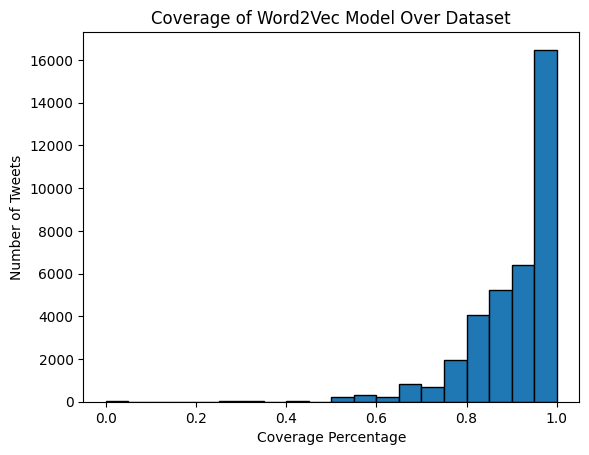

In [5]:
def calculate_coverage(tweet, word_vectors):
    words = tweet.split()
    in_vocab = sum(word in word_vectors for word in words)
    return in_vocab / len(words) if words else 0

train_data['Coverage'] = train_data['Text'].apply(lambda tweet: calculate_coverage(tweet, word2vec_greek_model))

average_coverage = train_data['Coverage'].mean()
print(f"Average coverage: {average_coverage:.2f}")

import matplotlib.pyplot as plt

plt.hist(train_data['Coverage'], bins=20, edgecolor='black')
plt.xlabel('Coverage Percentage')
plt.ylabel('Number of Tweets')
plt.title('Coverage of Word2Vec Model Over Dataset')
plt.show()

# Convert List of Embeddings to PyTorch tensors

In [6]:
import torch
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

# train tensors

train_embeddings_list = train_data['Embeddings'].apply(np.array).tolist()
train_embeddings_tensor = torch.tensor(np.stack(train_embeddings_list), dtype=torch.float)

train_sentiments = label_encoder.fit_transform(train_data['Sentiment'])
train_sentiments_tensor = torch.tensor(train_sentiments, dtype=torch.long)

# valid tensors

valid_embeddings_list = valid_data['Embeddings'].apply(np.array).tolist()
valid_embeddings_tensor = torch.tensor(np.stack(valid_embeddings_list), dtype=torch.float)

valid_sentiments = label_encoder.fit_transform(valid_data['Sentiment'])
valid_sentiments_tensor = torch.tensor(valid_sentiments, dtype=torch.long)

# Create the Neural Network

In [7]:
import torch.nn as nn
import torch.nn.functional as F

class SentimentClassifier(nn.Module):
    def __init__(self, embedding_size=100):
        super(SentimentClassifier, self).__init__()
        # embedding_size (100) inputs and 128 features outputs
        self.linear1 = nn.Linear(embedding_size, 128)
        self.batch1 = nn.BatchNorm1d(128) # batch normamlization
        
        # dropout layer
        # self.dropout = nn.Dropout(0.5) # 50% probablitiy
        self.dropout = nn.Dropout(0.3) # 30% probablitiy
        
        # Hidden layer
        # 128 inputs from linear 64 features outputs
        self.linear2 = nn.Linear(128, 64)
        self.batch2 = nn.BatchNorm1d(64)
        
        # 64 inputs from hiden layer and 3 (sentiment classes) features outputs
        self.linear3 = nn.Linear(64, 3)
        
    def forward(self, x):
        x = F.relu(self.batch1(self.linear1(x)))
        x = self.dropout(x)
        x = F.relu(self.batch2(self.linear2(x)))
        x = self.dropout(x)
        x = self.linear3(x)
        return x
    
model = SentimentClassifier(embedding_size=100)

# Training Loop

# Grid Search

In [8]:
# from torch.utils.data import TensorDataset, DataLoader
# import torch.optim as optim
# import matplotlib.pyplot as plt
# from sklearn.metrics import classification_report, accuracy_score

# params_grid = {
#     'learning_rate': [0.01, 0.001, 0.0001],
#     'batch_size': [32, 64, 128],
#     'num_epochs': [50, 100]
# }

# loss_func = nn.CrossEntropyLoss()

# performance_record = []

# train_tensor_dataset = TensorDataset(train_embeddings_tensor, train_sentiments_tensor)
# valid_tensor_dataset = TensorDataset(valid_embeddings_tensor, valid_sentiments_tensor)

# for lr in params_grid['learning_rate']:
#     for batch_size in params_grid['batch_size']:
#         for num_epochs in params_grid['num_epochs']:
#             model = SentimentClassifier()
#             optimizer = optim.Adam(model.parameters(), lr=lr)
#             scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)
            
#             train_loader = DataLoader(train_tensor_dataset, batch_size=batch_size, shuffle=True)
#             valid_loader = DataLoader(valid_tensor_dataset, batch_size=batch_size, shuffle=True)
            
#             epoch_losses = []
            
#             for epoch in range(num_epochs):
#                 model.train()
#                 train_losses, train_accuracies = [], []
#                 for inputs, labels in train_loader:
#                     # Delete previously stored gradients
#                     optimizer.zero_grad()
#                     output = model(inputs)        
#                     loss = loss_func(output, labels)
#                     loss.backward()
                    
#                     # Update model's weight
#                     optimizer.step()

#                     train_losses.append(loss.item())
#                     _, predicted = torch.max(output.data, 1)
#                     accuracy = (predicted == labels).float().mean()
#                     train_accuracies.append(accuracy.item())
                    
#                 scheduler.step()  
#                 avg_train_loss = sum(train_losses) / len(train_losses)
#                 avg_train_accuracy = sum(train_accuracies) / len(train_accuracies)
#                 epoch_losses.append(avg_train_loss)
#                 print(f'Epoch {epoch+1}: Train Loss = {avg_train_loss:.5f}, Train Accuracy = {avg_train_accuracy:.5f}')

#             validation_loss = 0.0
#             correct_predictions = 0
#             total_predictions = 0
            
#             model.eval()
#             with torch.no_grad():
#                 for inputs, labels in valid_loader:
#                     output = model(inputs)
#                     loss = loss_func(output, labels)
#                     validation_loss += loss.item()
                    
#                     _, predicted = torch.max(output, 1)
#                     total_predictions += labels.size(0)
#                     correct_predictions += (predicted == labels).sum().item()
            
#             validation_loss /= len(valid_loader)
#             validation_accuracy = correct_predictions / total_predictions
            
#             performance_record.append({
#                 'learning_rate': lr,
#                 'batch_size': batch_size,
#                 'num_epochs': num_epochs,
#                 'validation_loss': validation_loss,
#                 'validation_accuracy': validation_accuracy,
#             })
#             print(f"Completed: LR={lr}, Batch Size={batch_size}, Epochs={num_epochs}, Val Acc={validation_accuracy:.5f}")

# max(performance_record, key=lambda x: x['validation_accuracy'])

# best_performance = max(performance_record, key=lambda x: x['validation_accuracy'])
# print("Best Hyperparameters:")
# print(f"Learning Rate: {best_performance['learning_rate']}")
# print(f"Batch Size: {best_performance['batch_size']}")
# print(f"Number of Epochs: {best_performance['num_epochs']}")
# print(f"Validation Loss: {best_performance['validation_loss']:.5f}")
# print(f"Validation Accuracy: {best_performance['validation_accuracy']:.5f}")

# Using the best params

In [9]:
def train(model, train_loader, optimizer, loss_func):
    model.train()
    train_loss, train_acc = 0, 0
    all_labels, all_preds = [], []
    
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_func(outputs, labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        accuracy = (predicted == labels).float().mean()
        train_acc += accuracy.item()
        
        all_labels.extend(labels.tolist())
        all_preds.extend(predicted.tolist())
        
    avg_train_loss = train_loss / len(train_loader)
    avg_train_acc = train_acc / len(train_loader)
    
    return avg_train_loss, avg_train_acc, all_labels, all_preds

In [10]:
def evaluate(model, valid_loader, loss_func):
    model.eval()
    valid_loss, valid_acc = 0, 0
    all_labels, all_preds = [], []
    
    with torch.no_grad():
        for inputs, labels in valid_loader:
            outputs = model(inputs)
            loss = loss_func(outputs, labels)
            
            valid_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            accuracy = (predicted == labels).float().mean()
            valid_acc += accuracy.item()
            
            all_labels.extend(labels.tolist())
            all_preds.extend(predicted.tolist())
        
    avg_valid_loss = valid_loss / len(valid_loader)
    avg_valid_acc = valid_acc / len(valid_loader)
    
    return avg_valid_loss, avg_valid_acc, all_labels, all_preds

Epoch 1 Training:
Loss: 1.112, Accuracy: 0.356, Classification Report:
              precision    recall  f1-score   support

           0       0.35      0.38      0.36     12210
           1       0.36      0.32      0.34     12210
           2       0.36      0.37      0.36     12210

    accuracy                           0.36     36630
   macro avg       0.36      0.36      0.36     36630
weighted avg       0.36      0.36      0.36     36630

Epoch 1 Validation:
Loss: 1.087, Accuracy: 0.385, Classification Report:
              precision    recall  f1-score   support

           0       0.39      0.39      0.39      1744
           1       0.41      0.28      0.33      1744
           2       0.37      0.49      0.42      1744

    accuracy                           0.39      5232
   macro avg       0.39      0.39      0.38      5232
weighted avg       0.39      0.39      0.38      5232

Epoch 2 Training:
Loss: 1.090, Accuracy: 0.377, Classification Report:
              precision

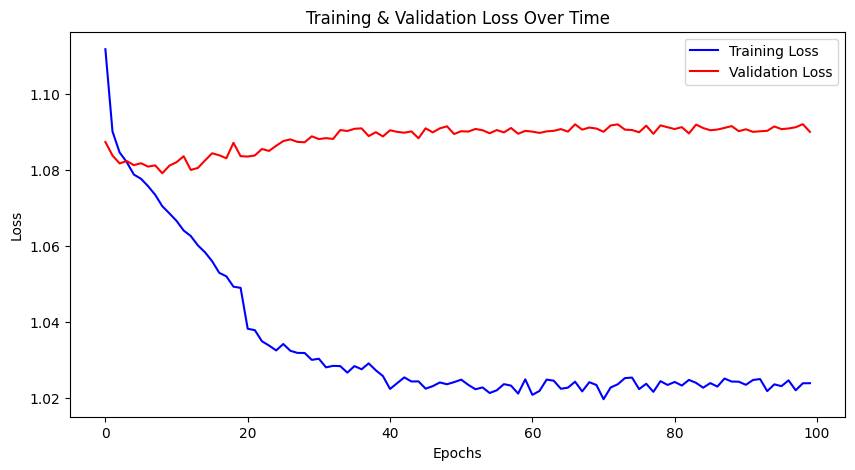

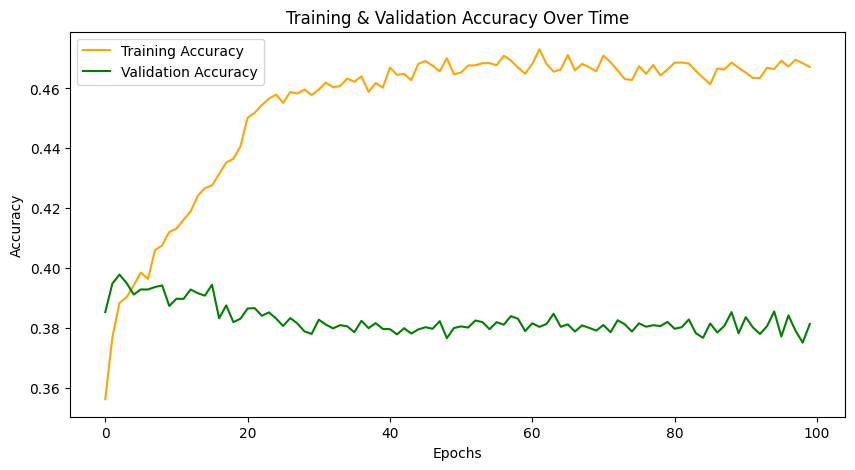

In [11]:
from torch.utils.data import TensorDataset, DataLoader
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, accuracy_score

train_tensor_dataset = TensorDataset(train_embeddings_tensor, train_sentiments_tensor)
valid_tensor_dataset = TensorDataset(valid_embeddings_tensor, valid_sentiments_tensor)

loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
# every step_size epochs the lr will be reduced by (gamma*100)%
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)

train_loader = DataLoader(train_tensor_dataset, batch_size=128, shuffle=True)
valid_loader = DataLoader(valid_tensor_dataset, batch_size=128, shuffle=True)

train_epoch_loss, valid_epoch_loss = [], []
train_epoch_acc, valid_epoch_acc = [], []

for epoch in range(100):
    train_loss, train_acc, train_labels, train_preds = train(model, train_loader, optimizer, loss_func)
    valid_loss, valid_acc, valid_labels, valid_preds = evaluate(model, valid_loader, loss_func)
    
    scheduler.step()

    train_epoch_loss.append(train_loss)
    valid_epoch_loss.append(valid_loss)
    
    train_epoch_acc.append(train_acc)
    valid_epoch_acc.append(valid_acc)
    
    # Classification report and accuracy for training data
    train_classification_report = classification_report(train_labels, train_preds, zero_division=0)
    train_accuracy = accuracy_score(train_labels, train_preds)
    print(f'Epoch {epoch+1} Training:')
    print(f'Loss: {train_loss:.3f}, Accuracy: {train_accuracy:.3f}, Classification Report:\n{train_classification_report}')

    # Classification report and accuracy for validation data
    valid_classification_report = classification_report(valid_labels, valid_preds, zero_division=0)
    valid_accuracy = accuracy_score(valid_labels, valid_preds)
    print(f'Epoch {epoch+1} Validation:')
    print(f'Loss: {valid_loss:.3f}, Accuracy: {valid_accuracy:.3f}, Classification Report:\n{valid_classification_report}')

# Combined plot for both Training and Validation Loss
plt.figure(figsize=(10, 5))
plt.plot(train_epoch_loss, label='Training Loss', color='blue')
plt.plot(valid_epoch_loss, label='Validation Loss', color='red')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training & Validation Loss Over Time')
plt.legend()
plt.show()

# Combined plot for both Training and Validation Accuracy
plt.figure(figsize=(10, 5))
plt.plot(train_epoch_acc, label='Training Accuracy', color='orange')
plt.plot(valid_epoch_acc, label='Validation Accuracy', color='green')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training & Validation Accuracy Over Time')
plt.legend()
plt.show()

# Confusion Matrices for Training and Validation

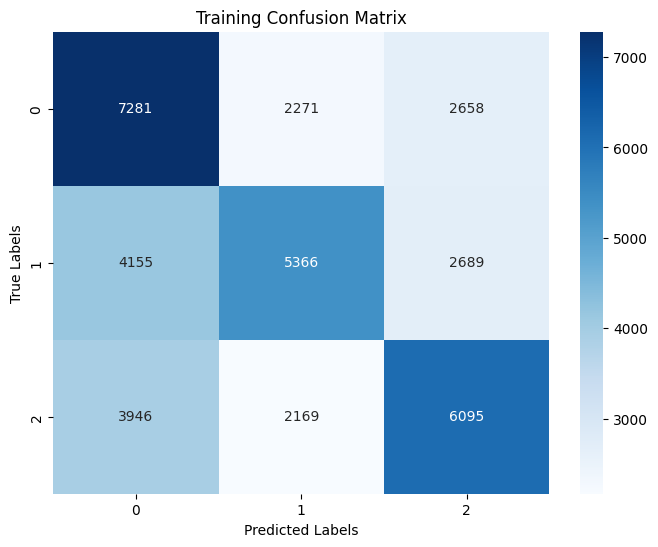

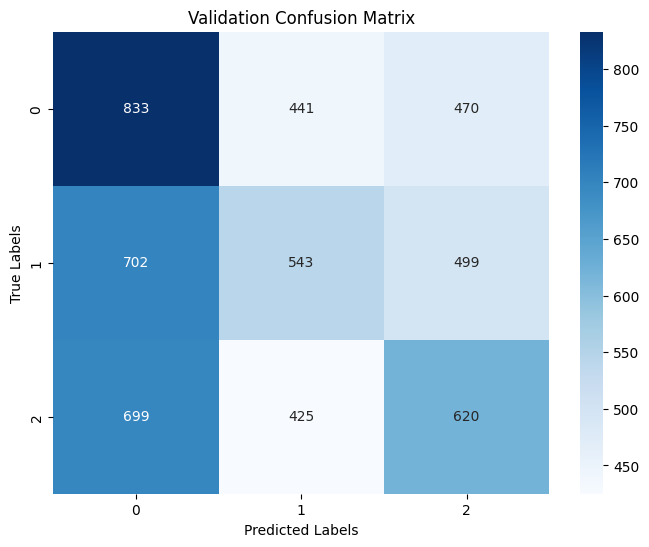

In [12]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

model.eval()

train_true_labels, train_predicted_labels = [], []
with torch.no_grad():
    for inputs, labels in train_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        train_true_labels.extend(labels.tolist())
        train_predicted_labels.extend(predicted.tolist())

train_cm = confusion_matrix(train_true_labels, train_predicted_labels)
# Confusion Matrix for Training
plt.figure(figsize=(8, 6))
sns.heatmap(train_cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Training Confusion Matrix')
plt.show()

valid_true_labels, valid_predicted_labels = [], []
with torch.no_grad():
    for inputs, labels in valid_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        valid_true_labels.extend(labels.tolist())
        valid_predicted_labels.extend(predicted.tolist())

cm = confusion_matrix(valid_true_labels, valid_predicted_labels)
# Confusion Matrix for Validation
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Validation Confusion Matrix')
plt.show()


In [13]:
test_data['Embeddings'] = test_data['Text'].apply(lambda tweet: tweets_to_embedding(tweet, word2vec_greek_model))

# test tensor

test_embeddings_list = test_data['Embeddings'].apply(np.array).tolist()
test_embeddings_tensor = torch.tensor(np.stack(test_embeddings_list), dtype=torch.float)

# no Sentiment labels to create a dataset
test_loader = DataLoader(test_embeddings_tensor, batch_size=128, shuffle=True)

model.eval()
test_predictions = []
with torch.no_grad():
    for inputs in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        test_predictions.extend(predicted.tolist())
        
predicted_sentiment_labels = label_encoder.inverse_transform(test_predictions)

predictions_df = pd.DataFrame({
    'Id': range(1, len(test_data) + 1),
    'Predicted': predicted_sentiment_labels})
predictions_df.to_csv('submission.csv', index=False)